[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

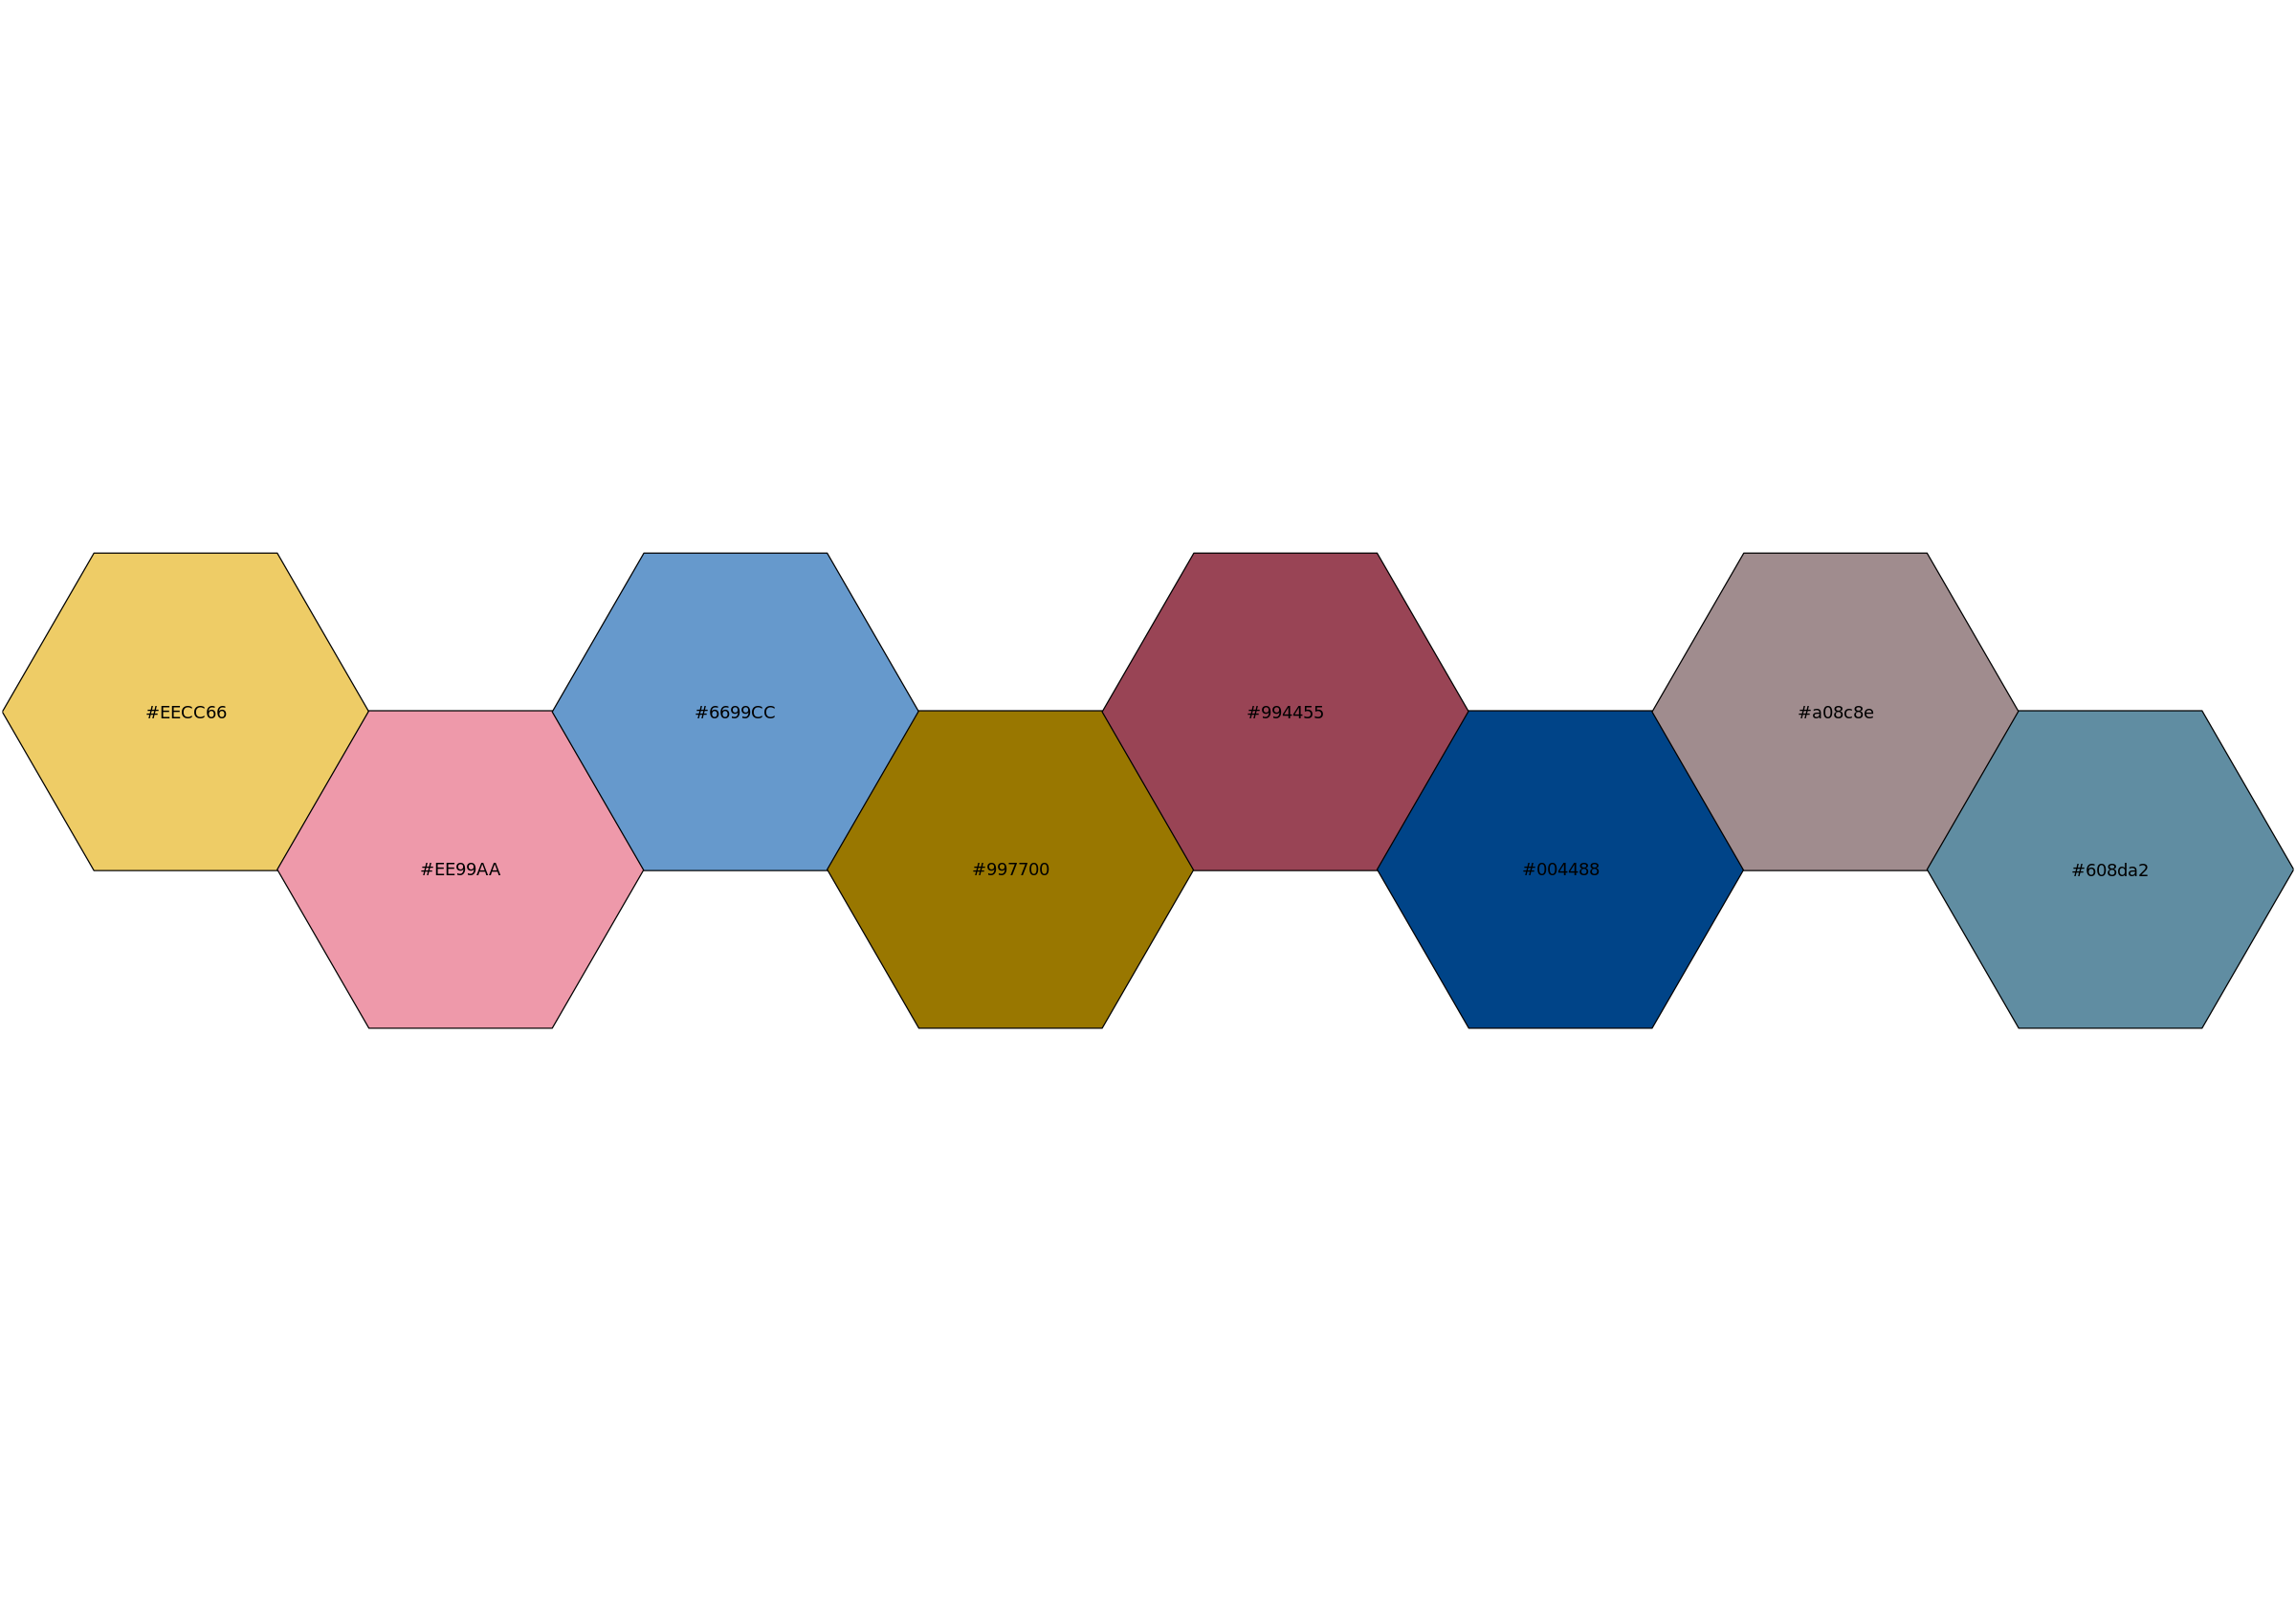

In [12]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [13]:
sample_nm <- c()
step_nm <- c()
for (file in list.files(SPL_STATS_DIR, pattern = "R1")){
    sample_nm <- c(sample_nm, unlist(strsplit(file, '_'))[1])
    step_nm <- c(step_nm, paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4]))
}
mt <- matrix(ncol = length(unique(sample_nm)), nrow = length(unique(step_nm)))
colnames(mt) <- unique(sample_nm)
rownames(mt) <- unique(step_nm)
for (file in list.files(SPL_STATS_DIR)){
    sample <- unlist(strsplit(file, '_'))[1]
    step <- paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4])
    line_count <- read.csv(file = paste0(SPL_STATS_DIR,file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
    mt[step, sample] <- line_count[1,1]
}

In [14]:
nm_oi <- list_oi <- c("Archaea", "Bacteria", "Fungi", "Viruses", "Homo sapiens")
mt_t <- matrix(ncol = 6, nrow = length(nm_oi))
colnames(mt_t) <- c("genome", "conf", "sample", "type", "value", "taxa")
rownames(mt_t) <- nm_oi

if(exists("default_df")){rm("default_df")}
for (file in list.files(SPL_K2pb_REP, recursive = TRUE, pattern = paste0(fav_threshold, ".report"))){
    mt_tmp <- mt_t
    gnm <- gsub(file, pattern = "/.*", replacement = "")
    mt_tmp[,"genome"] <- gnm
    smpl <- gsub(gsub(file, pattern = "_conf.*", replacement = ""), pattern = ".*/", replacement = "")
    mt_tmp[,"sample"] <- smpl
    mt_tmp[,"conf"] <- gsub(gsub(gsub(file, pattern = ".report", replacement = ""), 
                                               pattern = ".*_", replacement = ""), 
                                               pattern = "conf", replacement = "")
    
    k2prep <- read.csv(paste0(SPL_K2pb_REP, file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
    k2prep$V8 <- str_trim(k2prep$V8, side = "left")
    for (i in nm_oi){
        mt_tmp[i,"type"] <- i
        mt_tmp[i,"value"] <- as.numeric(k2prep$V2[which(k2prep$V8 == i)])
    }

    QC_rc <- mt["04adapt", smpl]
    mt_tmp[,"value"] <- as.numeric(mt_tmp[,"value"])/QC_rc*10^6
    
    mt_tmp[,"taxa"] <- rownames(mt_tmp)
    if(!exists("default_df")){default_df <- mt_tmp} else {default_df <- rbind(default_df, mt_tmp)}
}

In [15]:
host_mapping_data <-  sweep(mt,2,mt[4,],'/') %>% melt(value.name = "line_count", varnames = c("step", "sample")) %>% 
    mutate(line_count = line_count * 100) %>% 
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, external controls", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, external controls", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>% 
    filter(sample %nin% c("H02Bctrl", "H23Bctrl")) %>% 
    filter(!grepl(step, pattern = "0[1-4]")) %>%     
    mutate(step = ifelse(grepl(step, pattern = "05host"), "CHM13v2\n& GRCh38.p14", 
                    ifelse(grepl(step, pattern = "XXgrch38"), "GRCh38.p14", 
                    ifelse(grepl(step, pattern = "XXchm13"), "CHM13v2", NA))))  %>% 
    mutate(step = factor(step, levels = c("GRCh38.p14", "CHM13v2", "CHM13v2\n& GRCh38.p14")))

stat.test_prebuild <- host_mapping_data %>% t_test(line_count ~ step, paired = TRUE, 
                             p.adjust.method="bonferroni", 
                             var.equal = sample, 
                             alternative = "greater") 

host_mapping_plus <- host_mapping_data %>% 
    ggplot(aes(x = step, y = line_count)) + 
        geom_dotplot(aes(fill = sample_short), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(col = step), width = 0.4, fill = NA, size = 1.5) +
        theme_bw() + theme(plot.title = element_text(hjust = 0.5, face = "bold")) + 
        labs(x = "", y = "% reads", fill = "") + 
        stat_pvalue_manual(size = 7, stat.test_prebuild, label = "p.adj.signif", y.position = c(8,8.5,9)) + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c("black", as.character(colors_mc[c(4,1)])), 1)) + 
        geom_text(size=6, nudge_x = 0.3, 
            data = host_mapping_data %>% mutate(line_count = as.numeric(line_count)) %>% group_by(step) %>% 
                  summarise(meanY_10 = c(round(mean(line_count), digits = 2)), 
                            labY = paste0("mu=", round(mean(line_count), digits = 2))),
                  aes(x = step, y = meanY_10, label = labY)) + guides(color = FALSE) 

In [16]:
k2_prebuild_data <- as.data.frame(default_df) %>% 
    mutate(conf = as.character(conf)) %>%
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, external controls", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, external controls", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>%  
    filter(sample %nin% c("H02Bctrl", "H23Bctrl"))  %>% 
    mutate(value = as.numeric(value)) %>% 
    mutate(genome = ifelse(grepl(genome, pattern = "chm13_grch38"), "GRCh38.p14\n& CHM13v2", 
                    ifelse(grepl(genome, pattern = "grch38"), "GRCh38.p14", 
                    ifelse(grepl(genome, pattern = "chm13"), "CHM13v2", NA))))  %>% 
    mutate(genome = factor(genome, levels = c("GRCh38.p14", "CHM13v2", "GRCh38.p14\n& CHM13v2"))) 

k2_prebuild_norm <- k2_prebuild_data
for (r in 1:nrow(k2_prebuild_norm)){
    devide <- k2_prebuild_norm %>% 
        filter(genome == "GRCh38.p14") %>% 
        filter(conf == k2_prebuild_norm$conf[r]) %>% 
        filter(sample == k2_prebuild_norm$sample[r]) %>% 
        filter(type == k2_prebuild_norm$type[r]) %>% 
        filter(taxa == k2_prebuild_norm$taxa[r]) %>% 
        filter(sample_short == k2_prebuild_norm$sample_short[r]) %>% select(value) 
    k2_prebuild_norm[r,"value"] = k2_prebuild_norm[r,"value"]/devide 
}

stat.test_prebuild <- k2_prebuild_data %>% 
    filter(taxa == "Fungi") %>%
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    group_by(taxa) %>% 
        t_test(value ~ genome, paired = TRUE, 
            p.adjust.method="bonferroni", 
            var.equal = sample, alternative = "greater")  %>% 
        mutate(p.adj.signif = ifelse(p.adj.signif == "", "#", no = p.adj.signif))

fng_k2_standard <- k2_prebuild_norm %>% 
    filter(taxa == "Fungi") %>% 
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    ggplot(aes(x = genome, y = value)) + 
        geom_dotplot(aes(fill = sample_short), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(col = genome), width = 0.4, size = 1, fill = NA) + 
        theme_bw() + theme(panel.spacing.y = unit(2, "lines"), 
                            plot.title = element_text(hjust = 0.5, face = "bold"), 
                            strip.background = element_blank()) + 
        labs(x = "", y = "Fungi RPM, normalized", fill = "") + 
        stat_pvalue_manual(size = 7, stat.test_prebuild, 
                           label = "p.adj.signif", y.position = c(1.1125,1.15,1.1875)) +
        geom_hline(yintercept = 1.0375) + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c("black", as.character(colors_mc[c(4,1)])), 1)) + 
        guides(color = FALSE) + xlab("") +
        scale_y_continuous(breaks = seq(0.4,1.00,0.1), limits = c(0.4,1.1875), labels = seq(0.40,1.00,0.1)) +
        geom_text(size = 6,position = position_dodge(0.5), hjust = 0.5,
            data = k2_prebuild_data %>% 
                  filter(taxa == "Fungi") %>% 
                  filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% group_by(taxa, genome) %>% 
                  summarise(meanY = c(round(mean(value), digits = 2)), 
                        labY = paste0("mu=", round(mean(value), digits = 2)), .groups = "keep"),
                  aes(x = genome, y = 1.075, label = labY)) 

In [17]:
nm_oi <- list_oi <- c("Archaea", "Bacteria", "Fungi", "Viruses", "Homo sapiens")
mt_t <- matrix(ncol = 7, nrow = length(nm_oi))
colnames(mt_t) <- c("sample", "taxa", "db", "conf",
                    "percentage", "count", "minimizers_est")
rownames(mt_t) <- nm_oi

if(exists("build_df")){rm("build_df")}
for (file in list.files(SPL_K2_REP, recursive = TRUE, pattern = paste0("conf0.0.report"))){
    if(grepl(file, pattern = "_RS")){
        mt_tmp <- mt_t
        smpl <- gsub(file, pattern = "_.*", replacement = "")
        mt_tmp[,"sample"] <- gsub(file, pattern = "_.*", replacement = "")
        mt_tmp[,"conf"] <- gsub(gsub(gsub(file, pattern = ".report", replacement = ""), 
                                               pattern = ".*_", replacement = ""), 
                                               pattern = "conf", replacement = "")
        smpl_db <- gsub(gsub(file, pattern = "_conf.*", replacement = ""), pattern = ".*/", replacement = "")
        
        if(grepl(file, pattern = "_RS_conf")){mt_tmp[,"db"] <- "RS"}
        if(grepl(file, pattern = "_RS_minusT2T_conf")){mt_tmp[,"db"] <- "RS w/o CHM13v2"}                                          

        k2prep <- read.csv(paste0(SPL_K2_REP, file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
        k2prep$V8 <- str_trim(k2prep$V8, side = "left")
        for (i in nm_oi){
            mt_tmp[i,"taxa"] <- i
            mt_tmp[i,"count"] <- as.numeric(k2prep$V2[which(k2prep$V8 == i)])
            mt_tmp[i,"minimizers_est"] <- as.numeric(k2prep$V5[which(k2prep$V8 == i)])
        }

        QC_rc <- mt["04adapt", smpl]
        mt_tmp[,"percentage"] <- as.numeric(mt_tmp[,"count"])/QC_rc*10^6

        if(!exists("build_df")){build_df <- mt_tmp} else {build_df <- rbind(build_df, mt_tmp)}
    }
}

k2_build_data <- data.frame(build_df) %>% 
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, external controls", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, external controls", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>%  
    filter(sample %nin% c("H02Bctrl", "H23Bctrl"))  %>% 
    mutate(percentage = as.numeric(percentage)) %>%
    mutate(minimizers_est = as.numeric(minimizers_est)) %>% 
    mutate(count = as.numeric(count))  %>% 
    mutate(taxa = factor(taxa, levels = c("Homo sapiens", "Archaea", "Bacteria", "Fungi", "Viruses")))

In [18]:
k2_build_norm <- k2_build_data
for (i in 1:nrow(k2_build_data)){
    k2_build_norm[i,c("percentage", "count", "minimizers_est")] = 
        as.numeric(k2_build_norm[i,c("percentage", "count", "minimizers_est")])/ 
            as.numeric(k2_build_norm[which(k2_build_norm$sample == k2_build_norm$sample[i] &
            k2_build_norm$taxa == k2_build_norm$taxa[i] & 
            k2_build_norm$conf == k2_build_norm$conf[i] & 
            k2_build_norm$db == "RS w/o CHM13v2"), c("percentage", "count", "minimizers_est")]) 
}

stat.class_norm <- k2_build_norm %>% 
    filter(taxa == "Homo sapiens") %>% 
    mutate(taxa = paste0(taxa, " (S)")) %>%
    mutate(db = factor(db, levels = c("RS","RS w/o CHM13v2"))) %>% 
    t_test(percentage ~ db, paired = TRUE, 
                             p.adjust.method="bonferroni", 
                             var.equal = sample, 
                             alternative = "greater") %>% 
    mutate(p.stars = ifelse(p <= 0.0001, yes = "****", no = p))

host_class_norm <- k2_build_norm %>% 
    filter(taxa == "Homo sapiens") %>% 
    mutate(taxa = paste0(taxa, " (S)")) %>%
    mutate(db = factor(db, levels = c("RS w/o CHM13v2","RS"))) %>% 
    ggplot(aes(x = db, y = percentage)) + 
        geom_dotplot(aes(fill = sample_short), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(width = 0.4, col = colors_mc[1], fill = NA, size = 1.5) + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) +
        stat_pvalue_manual(size = 7, stat.class_norm, label = "p.stars", y.position = c(1.045)) + 
        theme_bw() + labs(y = "Homo Sapiens RPM, normalized", col = "", x = "") +
        guides(color = FALSE, fill = FALSE) + 
        geom_text(size = 6,
                  data = k2_build_data %>% 
                        filter(taxa == "Homo sapiens") %>% 
                        mutate(taxa = paste0(taxa, " (S)")) %>%
                        mutate(db = factor(db, levels = c("RS w/o CHM13v2","RS"))) %>%  
                        group_by(taxa, db) %>% 
                    summarise(meanY = round(mean(percentage), digits = 2), 
                        labY = paste0("mu=", round(mean(percentage), digits = 2)), .groups="keep"),
            aes(x = db, y = 1.040, label = labY)) + 
        scale_y_continuous(breaks = seq(1,1.035,0.01), limits = c(1,1.048), labels = seq(1,1.035,0.01)) +
        geom_hline(yintercept = 1.035) + 
        scale_x_discrete(labels=c(
                                "RS w/o CHM13v2" = "uR.7 w/o\nCHM13v2", "RS" = "uR.7 ", 
                                "EPRSc2" = "cRE.21", "EPRSFv46DM" = "dRE.21", "EPRSFv46MCAspDM" = "dREM.258", 
                                "EPRSFv64DM" = "dRE.31", "EPRSFv64MCAspDM" = "dREM.260")) 


In [19]:
stat.test_build <- k2_build_norm %>% 
    filter(taxa == "Fungi") %>%
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
    group_by(taxa) %>% 
        t_test(percentage ~ db, paired = TRUE, 
            p.adjust.method="bonferroni", 
            var.equal = sample, 
            alternative = "greater")  %>% 
    mutate(p = ifelse(is.na(p), "#", p)) %>% 
    mutate(p.stars = ifelse(p <= 0.0001, yes = "****", no = p))

fng_violin <- k2_build_norm %>% 
    filter(taxa == "Fungi") %>%
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
    ggplot() + 
        geom_dotplot(aes(fill = sample_short, x = db, y = percentage), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(x = db, y = percentage), col = colors_mc[1], fill = NA, width = 0.4, size = 1.5) + 
        theme_bw() + 
        theme(panel.spacing.y = unit(2, "lines"), 
                            plot.title = element_text(hjust = 0.5, face = "bold"), 
                            plot.subtitle = element_text(hjust = 0.5), 
                            strip.background = element_blank()) + 
        labs(x = "", y = "Fungi RPM, normalized", fill = "") + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c(as.character(colors_mc[c(1)])), 0.6)) + 
        stat_pvalue_manual(size = 7, stat.test_build, 
                           label = "p.stars", y.position = 1.025) +
        geom_text(size = 6,  
            data = k2_build_data %>% filter(taxa == "Fungi") %>% 
                        filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% mutate(db = factor(db, levels = c("RS w/o CHM13v2", "RS"))) %>% 
                        group_by(taxa, db) %>% 
                    summarise(meanY = round(mean(percentage), digits = 2), 
                        labY = paste0("mu=", round(mean(percentage), digits = 2)), .groups="keep"),
            aes(x = db, y = 1.0125, label = labY)) +  
        geom_hline(yintercept = 1.0075) + 
        scale_y_continuous(breaks = seq(0.9,1.00,0.025), limits = c(0.9,1.03125), labels = seq(0.9,1.00,0.025)) +
    theme_bw() + 
    scale_x_discrete(labels=c(
                            "RS w/o CHM13v2" = "uR.7 w/o\nCHM13v2", "RS" = "uR.7 ", 
                            "EPRSc2" = "cRE.21", "EPRSFv46DM" = "dRE.21", "EPRSFv46MCAspDM" = "dREM.258", 
                            "EPRSFv64DM" = "dRE.31", "EPRSFv64MCAspDM" = "dREM.260"))   

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of th

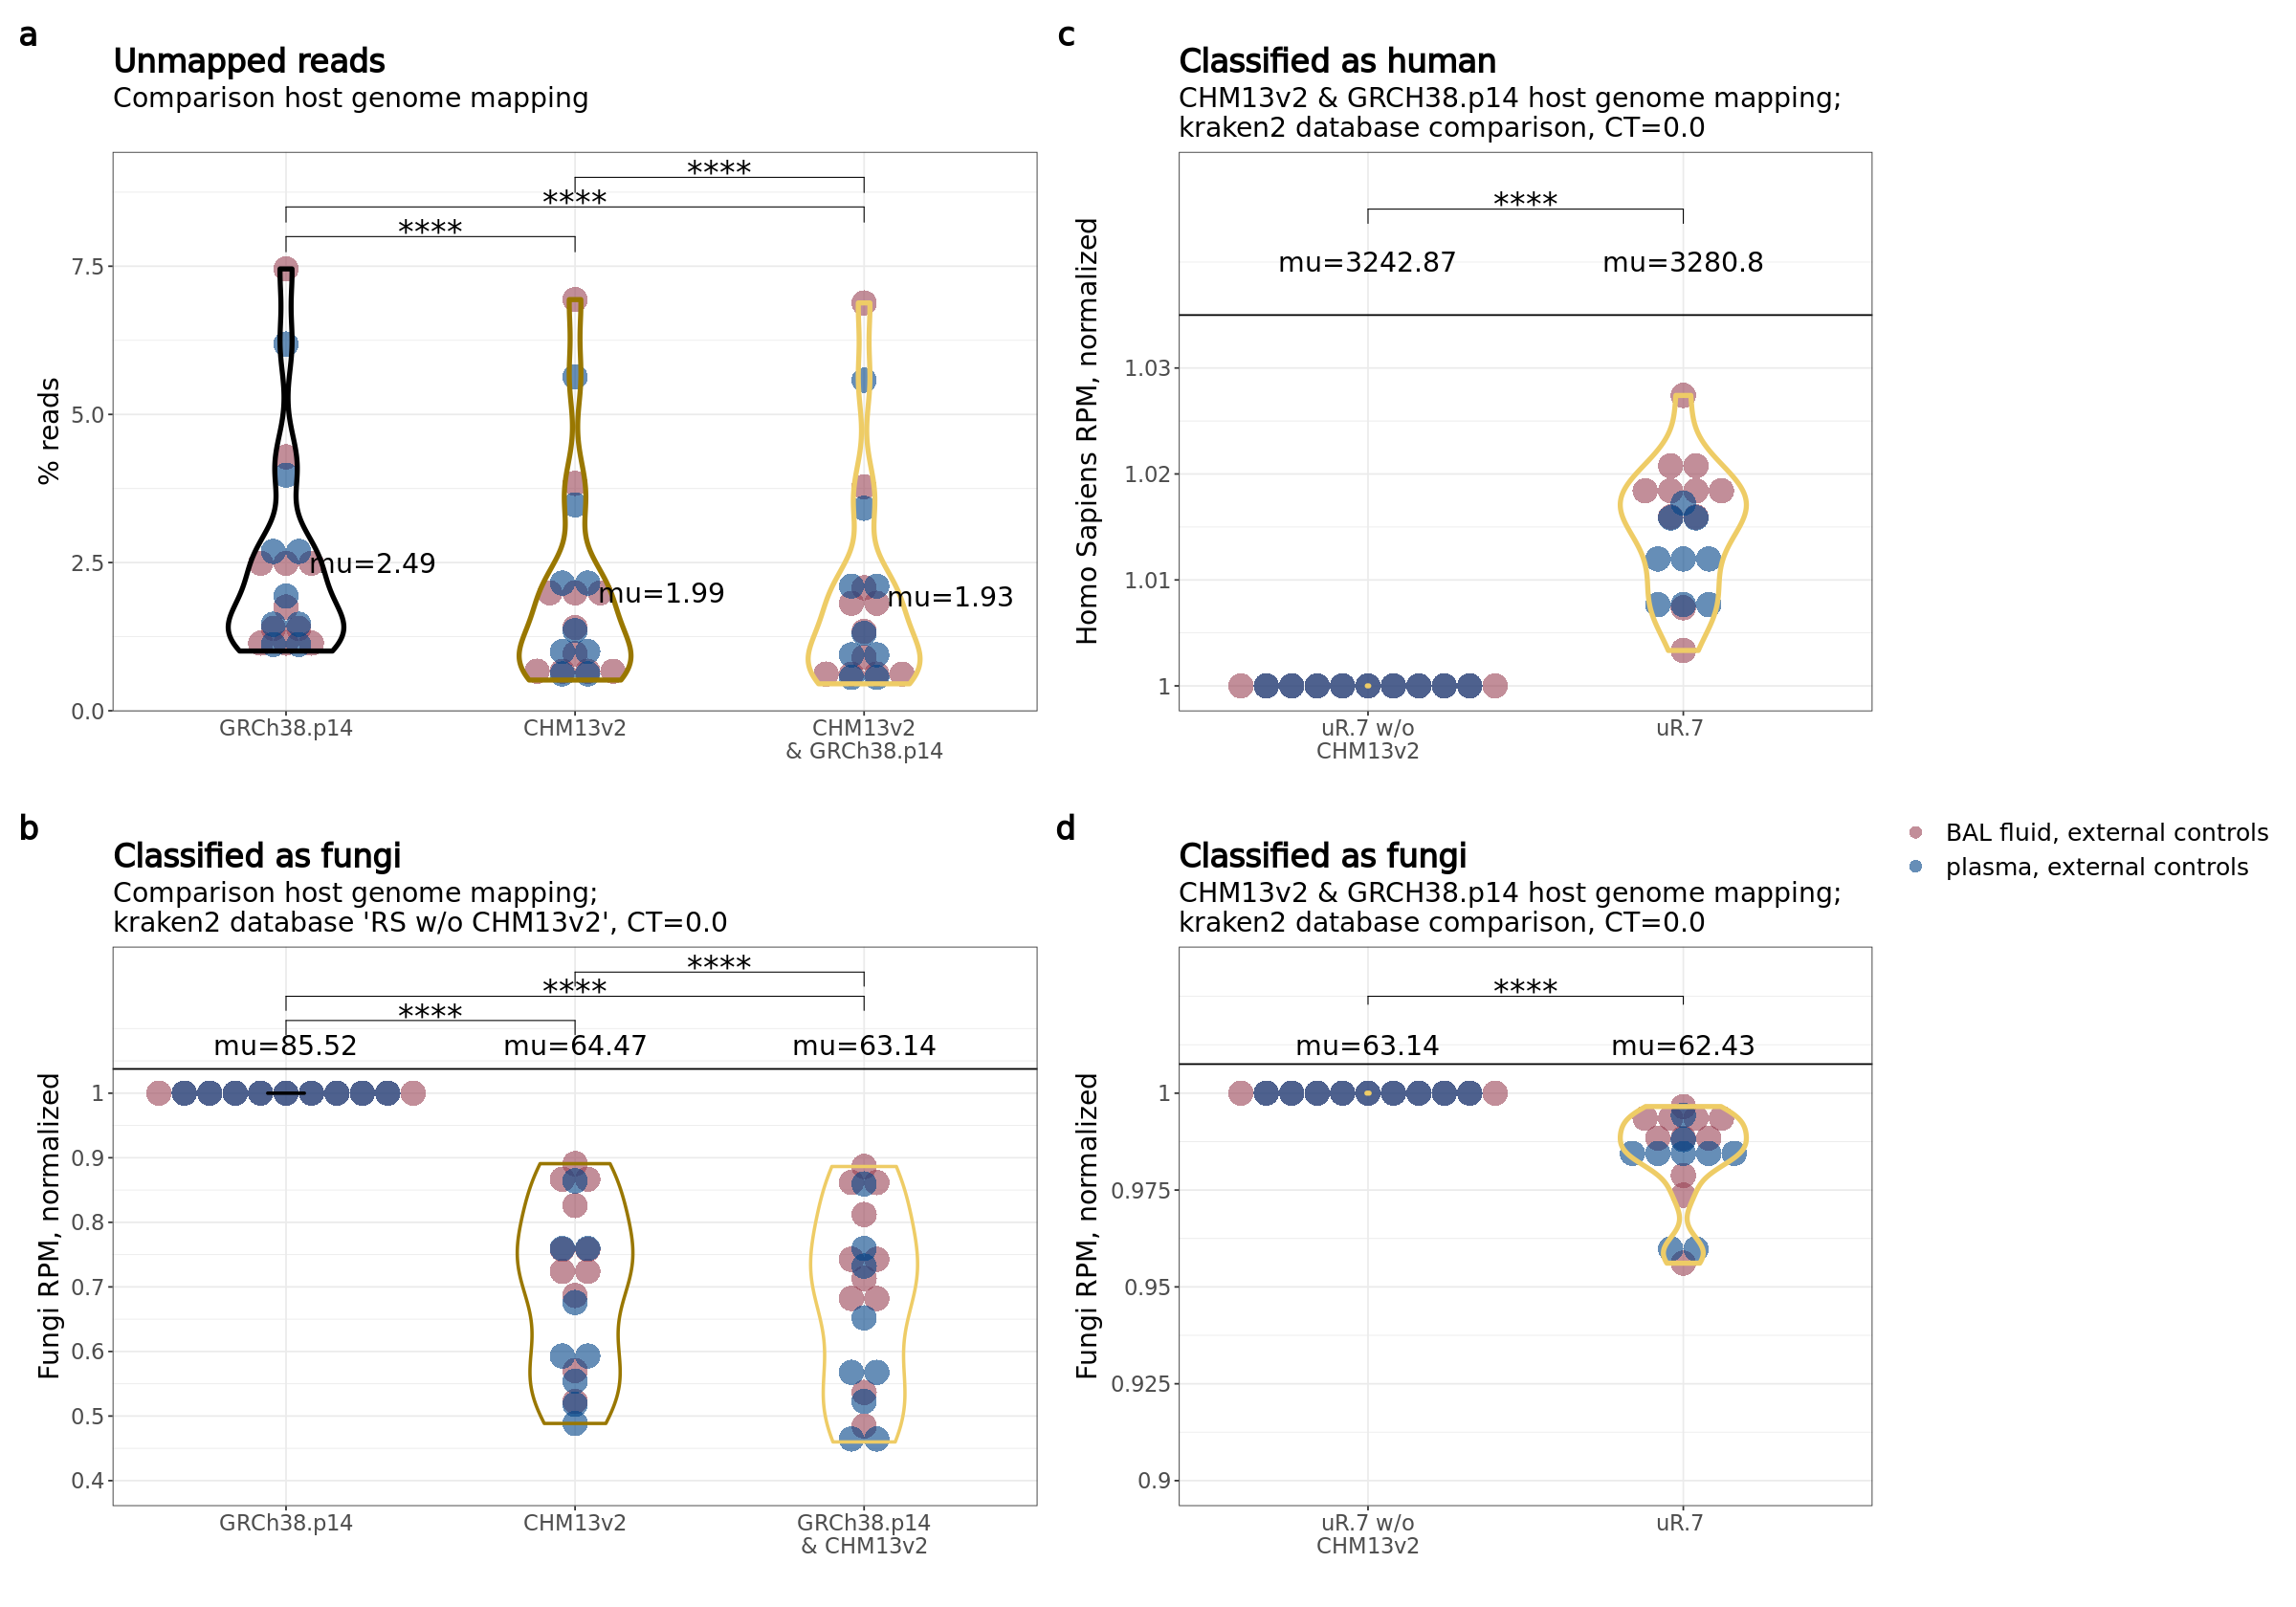

In [20]:
options(repr.plot.width=20, repr.plot.height=14)
layout <- "AC
           BD"
Fig2 <- (host_mapping_plus + ggtitle("Unmapped reads", 
            subtitle = "Comparison host genome mapping\n")) + 
        (fng_k2_standard + ggtitle("Classified as fungi", 
            subtitle = "Comparison host genome mapping;\nkraken2 database 'RS w/o CHM13v2', CT=0.0")) + 
        (host_class_norm + ggtitle("Classified as human", subtitle = "CHM13v2 & GRCH38.p14 host genome mapping;\nkraken2 database comparison, CT=0.0")) +
        (fng_violin + ggtitle("Classified as fungi", subtitle = "CHM13v2 & GRCH38.p14 host genome mapping;\nkraken2 database comparison, CT=0.0")) + 
        plot_layout(design = layout, guides="collect", widths = c(2,1.5)) &
            plot_annotation(tag_levels = 'a') &
            theme(legend.position='right', legend.justification='left', legend.direction = 'vertical',
                legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
                text = element_text(size = 17), legend.text = element_text(size = 15, colour = "black"),
                plot.title = element_text(size = 20, hjust = 0, face = "bold"), 
                plot.subtitle = element_text(size = 17, hjust = 0), 
                plot.tag = element_text(face = 'bold', size = 20))

Fig2

ggsave("../../output/figures/Fig2_R.png", 
       Fig2, width = 20, height = 14)
ggsave("../../output/figures/Fig2_R.pdf", 
       Fig2, width = 20, height = 14)